# Hypothesis Test - Kitchen - Results

Author: Dan E

Date: 2023-04-28

Description: This notebook will conclude the hypothesis testing of kitchen features from the start to finish. It will review the entire process of how the features were generated and the different successful and unsuccessful approaches. Some the predictions were run in a SageMaker notebook. For this stage we will document the steps involved here and how we would scale this process up in the future.

The notebook will consist of the following sections:

* Imports:
    * Setup
    * Packages
    * Data
 
* Introduction:
    * Statement of the hypothesis tests
    * Image data and extraction
    * Hugging Face
    
* Experiment Design:
    * Filtering specific images
    * Text generation
    
* Experiment Run:
    * Initial caption generation
    * Prompted text generation
    
* Results:
    * Hypothesis test statements
    * T-Test Results
    * Label Analysis
    * Modelling Analysis
    
* Conclusion:
    * Progress of this methodology
    * Limitations of this methodology
    * Next steps

## Imports

### Setup

The image captioning model was small enough to run locally (requires less than 4gb GPU memory). The version of pytorch, cuda and cuddn is given below. Note that pytorch only supports upto cuda 11.8 but cuda 12.1 still works on this version. The latest version of transforms is also required to run the models used.

In [1]:
torch_version = "2.0.0+cu118"
cuda_version = "12.1.0"
cuddn_version = "8.1.3"
transformers_version = "4.28.0.dev0"

### Packages

In [2]:
import pandas as pd
import numpy as np

from PIL import Image
from io import BytesIO
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
import os
from transformers import pipeline
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sqlalchemy.engine import URL
from sqlalchemy import create_engine, text
import platform
from pathlib import Path
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.stats.weightstats import ttest_ind

# Hack - Netskope issue
os.environ['CURL_CA_BUNDLE'] = ''

### Data

The data required for these hypothesis tests is as follows:
* Link to download images
* Properties and property features
* Revenue of last 12 months when available

These are all obtained using SQL queries in seperate files. They are loaded in here and then they are restricted to the control sample group. This is the following:

* WorkingRegion = North Wales
* Bedrooms = 2,3
* HoneyPot = True

They must also have not lapsed, withdrawn or stop sell during the last 12 months. They must also not violate owner booking criteria depending on the owner booking tier. This is to get a fair comparison in terms of property and the revenue they generate.

In [3]:
def fetch_SQLserver_data(sql_code,conn_string):
	"""
	Uses sqlalchemy and pandas.read_sql to return query results as dataframe.
	:param sql_code: string, query to be submitted
	:param conn_string: string, full connection details as string
	"""
	connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_string})
	engine = create_engine(connection_url)
	with engine.connect() as conn:
		df = pd.read_sql(sql=text(sql_code), con=conn)
		conn.commit()
	return df

if platform.system() == 'Windows':
	conn_CDM = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-02;DATABASE=CDM;trusted_connection=Yes'
	conn_l0 = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-02;DATABASE=Sykes_DW_Level0_Staging;trusted_connection=Yes'
	conn_l2 = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-02;DATABASE=Sykes_DW_Level2_ADM;trusted_connection=Yes'
	conn_BOX = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-02;DATABASE=Box;trusted_connection=Yes'

In [4]:
def get_query(_file):
	query_file = open(_file,'r')
	query = query_file.read()
	query_file.close()
	return query

In [5]:
# Property Features
property_features = get_query('data/property_features_cdm.sql')
df_property = fetch_SQLserver_data(property_features, conn_CDM)
df_nw = df_property.loc[df_property['WorkingRegion'] == 'North Wales'].copy()
df_nw = df_nw.loc[df_nw['Bedrooms'].isin([2,3])]
df_nw = df_nw.loc[df_nw['isHoneyPot'] == 1]

In [6]:
# Image Data
property_images = get_query('data/property_images.sql')
df_images = fetch_SQLserver_data(property_images, conn_l0)

In [7]:
# Revenue Data - Pulled in as flat file as SQL code does not work in the notebook
df_rev = pd.read_csv('data/revenue_test_2023_04_12.csv')

## Introduction

### Statement

The hypothesis that is being tested is that:

<p style="text-align: center;"> "Does the quality of the kitchen effect the revenue of a property" </p>

The above statement is subjective, the statement needs elaborating to make possible to test.

<p style="text-align: center;"> "Are there specific features dervied from images of a properties kitchen that effect the revenue of a property" </p>

The hypotheis testing then becomes testing on the features individually. The work is to create these features from images and the evaluation will be straight forward.

There are many options on how the features could de derived, I will list some of these below:

* Manually - this involves manually inspecting the images and creating descriptions and labels for the images. It requires specialized domain knowledge. It is therefore very slow and expensive and will require rule based methods to automate this to a large dataset. Then to automate this a image classifier model will be required to be built eventually.

* Object detection - this involves building an object detection model to classify all objects in images that are associated with kitchens. The training labels woiuld have to be manually generated and pre-trained models fined tuned to classify the objects. The limitation is that these objects might not be correlated to revenue, hence the work required is likely to be out-weighed but the potential gains.

* Image classification - this is part of the manual option above. It requires labels manually created and classifier models built on these labels directly. It skips the rule based and expert domain knowledge.

* Image to text generation - this can be combined with the image classifer above. The aim is to generate a description of images specially of the kitchens and create labels from the generated text. These can then be worked on manually to improve the labels and a classfier could be trained to generate the labels that are most suitable.

The option chosen in this notebook is the last option. We want to generate text from images and use this to create features and test for a difference in revenue. This requires a mixture of AI and human working together to find the bext solution.

### Images

The images use the image table from L0 and then loaded into memory using a GET request. We will show how the URLs are created, this is a quick solution as this significantly slows down model inference as the files have to be downloaded before inference or loaded in memory one at a time.

In [8]:
# Create image URL
df_sample = df_nw[['PropertyReference']].merge(df_images, on='PropertyReference')
df_sample.loc[:, 'URL'] = [f'https://images-cdn.sykesassets.co.uk/images/property_images/1500x1125/{x}/{y}' \
                           for x,y in zip(df_sample['PropertyReference'], df_sample['file_name'])]

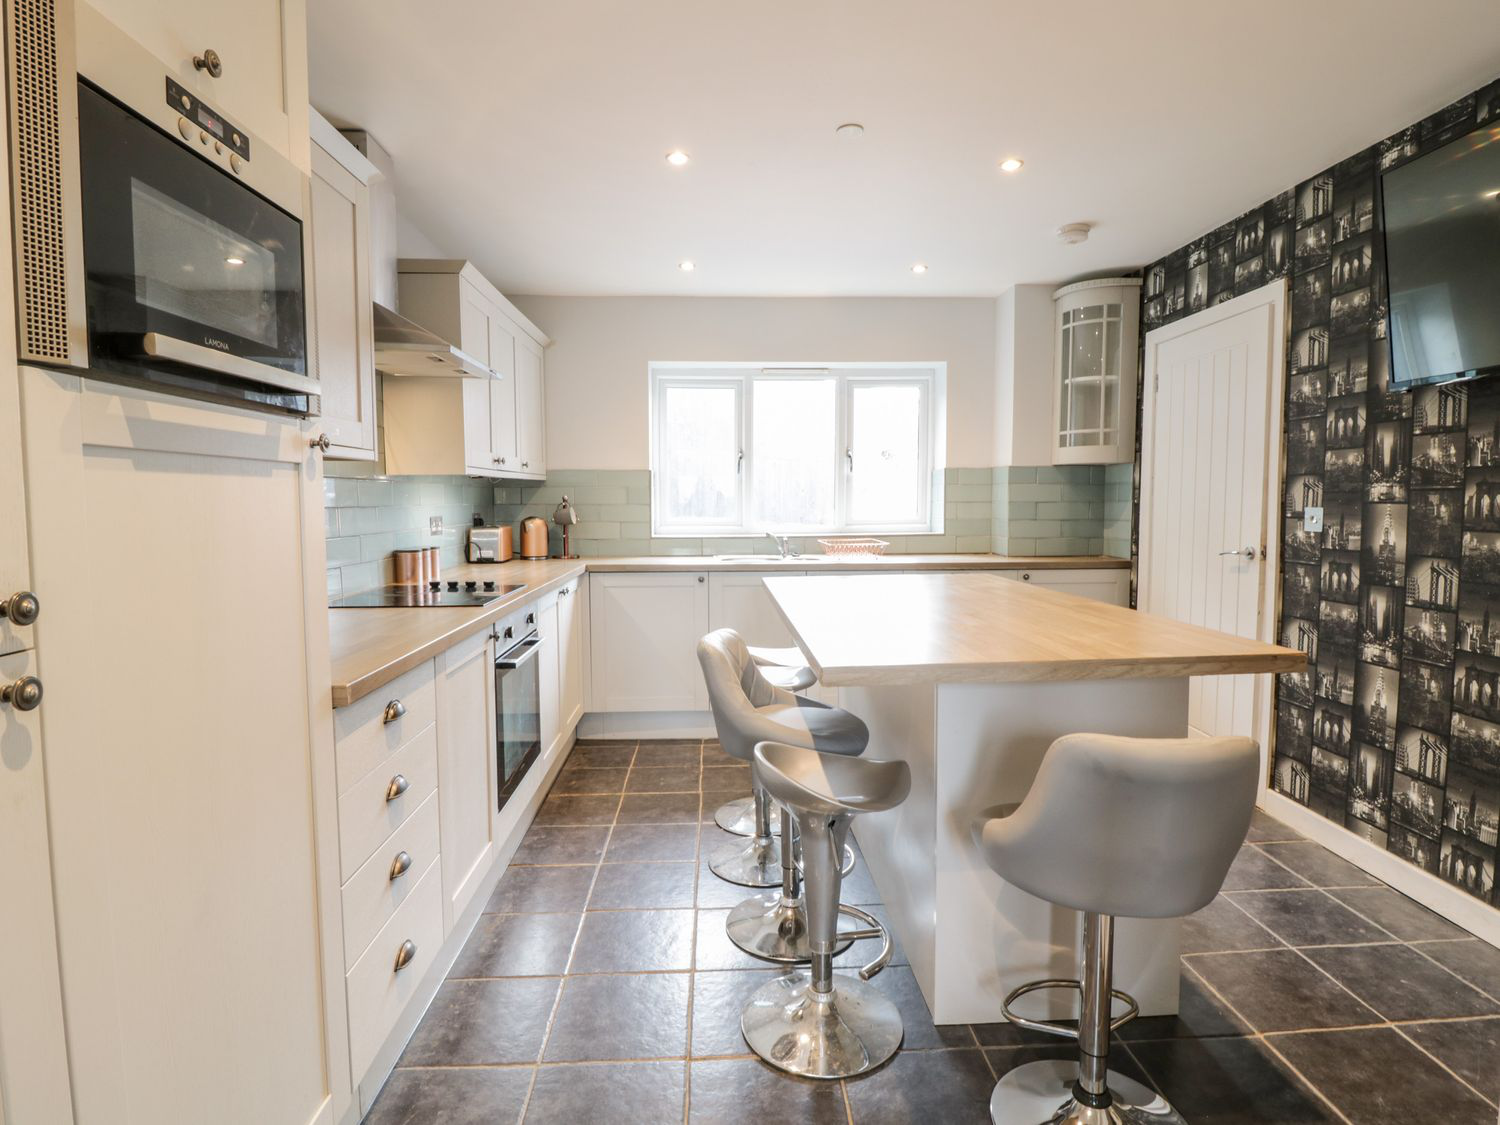

In [9]:
# View Image
#url = df_sample.sample(1).iloc[0].URL
url = 'https://images-cdn.sykesassets.co.uk/images/property_images/1500x1125/1044010/sc_15955184664778_1044010_002.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

### Models

The approach chosen requires Image to Text generation. We use two different types of models as they were the most suitable. Even these models have different options. The models are:

ViT - nlpconnect/vit-gpt2-image-captioning (Trained on COCO 2017 Dataset)

Paper - https://arxiv.org/abs/2010.11929

BLIP-2 - Salesforce/blip2-flan-t5-xxl (XXL produces best results)

Paper - https://arxiv.org/abs/2301.12597

Both of these models have different option in the LLM at the backend and the data is trained on.

#### ViT

In [10]:
#ViT - Settings
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

In [11]:
# Can use pipeline model instead of loading Tokenizer, Processor and Model Encoder/Decoder
model_vit = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor_vit = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer_vit = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [ ]:
# Switch model to CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
model_vit.to(device)

In [13]:
# Use Test Image above
pixel_values = feature_extractor_vit(images=image, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)
output_ids = model_vit.generate(pixel_values, **gen_kwargs)
preds = tokenizer_vit.batch_decode(output_ids, skip_special_tokens=True)
preds = [pred.strip() for pred in preds]
print(preds)

['a kitchen with a sink and a microwave']


#### BLIP-2

In [14]:
# Requires latest dev version of transformers to work (4.28.0)
processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xxl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xxl")

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
model

In [16]:
# Use Test Image Again
inputs = processor(image, return_tensors="pt")
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

a kitchen with a table and chairs


In [17]:
# Attempt prompt now
prompt = "The style of this kitchen is"

inputs = processor(image, text=prompt, return_tensors="pt")
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

modern and sleek with a large island


## Experiment Design

### Filtering

Use the initial model and pull out objects containing the word 'kitchen'

### Text Generation

Use the second model and prompt it to generate a style response

## Experiement Run

### Image Captioning

This is a simple model and can be run locally and quickly

### Prompted Text Generation

This takes significant time and this is where alternatives when available can be used.

## Results

The final results were evaluated on:

* Property Count: 610
* Image Count: 1953

Initially it was 45,000 images and 1,500 properties before filtering to kitchens and correct revenue labels.

This is images of kitchen with additional caption text generated using a text prompt.

The top occuring words were selected to generate the features, the same property might have different text generated for different images. Hence we ask different questions if the text is in all images for a property, some images for a property or no images for a property. For each word we will test three different hypothesis.

The next step is to test a label creation and see if this is suitable.

Then regression modelling is run to see the imapct of the created features below.

### Statements

Here we will generate the features to test the hypothesis on in the next subsection. The main tool is using a word vectoriser for the generated text from the image.

In [18]:
# Load complete data
df_kitchen = pd.read_csv('kitchen_caption_final.csv')

In [19]:
# one row of the caption and prompted text
df_kitchen.sample(1).iloc[0]

PropertyReference                                               928529
file_name                              sc_14430941439463_928529_10.jpg
height                                                             450
width                                                              600
position                                                             8
URL                  https://images-cdn.sykesassets.co.uk/images/pr...
Caption              ['a kitchen with a table, chairs, and a table ...
kitchen                                                              1
TestLabel                                                       2410.4
TestStartDate                                               09/04/2022
TestEndDate                                                 08/04/2023
BLIP-Caption                                   modern and contemporary
Name: 422, dtype: object

In [20]:
# just vectorise words for initial testing
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english')
X = vectorizer.fit_transform(df_kitchen['BLIP-Caption'].values)
df_blip_vectorise = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df_blip = df_kitchen.drop('kitchen', axis=1).reset_index(drop=True).join(df_blip_vectorise)
df_blip_vectorise.sum().sort_values(ascending=False).head(12)

modern          1722
sleek            547
wooden           542
contemporary     458
clean            383
traditional      314
floor            257
white            211
cabinets         130
table            126
rustic           117
twist             89
dtype: int64

In [21]:
# Top 12 words and percentage of images they are contained in the text generated
(100*df_blip_vectorise.sum()/df_blip_vectorise.shape[0]).sort_values(ascending=False).head(12)

modern          88.172043
sleek           28.008193
wooden          27.752176
contemporary    23.451101
clean           19.610855
traditional     16.077829
floor           13.159242
white           10.803891
cabinets         6.656426
table            6.451613
rustic           5.990783
twist            4.557092
dtype: float64

In [22]:
# specify key words to test manually - don't want p-hacking here
keywords = ['modern', 'sleek', 'contemporary', 'traditional', 'rustic']

### T-Tests

Now have 5 key words to test and 3 tests to run on the key words for a total of 15 tests. There is a risk the null hypothesis failing by random chance, hence why only specific key words were chosen.

The tests will be two-sided as we have no prior assumption what word should impact the revenue difference. We are only testing if there is a difference at all.

In [23]:
# create functions to create summary stats and run tests
def feature_revenue_difference(word, data=df_blip):
    df_temp = data[['PropertyReference', 'TestLabel', word]].groupby('PropertyReference').mean().copy()
    df_temp = df_temp.loc[df_temp[word].isin([1,0])].copy()
    df_comparison = df_temp.groupby(word).mean()
    percentage_diff = 100*(df_comparison.loc[1].values[0] - df_comparison.loc[0].values[0])/df_comparison.loc[0].values[0]
    return percentage_diff

def ttest_p_values(word, data=df_blip):
    df_temp = data[['PropertyReference', 'TestLabel', word]].groupby('PropertyReference').mean().copy()
    t1 = ttest_ind(df_temp.loc[df_temp[word].isin([1])].TestLabel.values,
                   df_temp.loc[df_temp[word].isin([0])].TestLabel.values,
                   alternative='two-sided',
                   usevar='pooled',
                   weights=(None, None),
                   value=0)
    t2 = ttest_ind(df_temp.loc[~df_temp[word].isin([0])].TestLabel.values,
                   df_temp.loc[df_temp[word].isin([0])].TestLabel.values,
                   alternative='two-sided',
                   usevar='pooled',
                   weights=(None, None),
                   value=0)
    t3 = ttest_ind(df_temp.loc[df_temp[word].isin([1])].TestLabel.values,
                   df_temp.loc[~df_temp[word].isin([1])].TestLabel.values,
                   alternative='two-sided',
                   usevar='pooled',
                   weights=(None, None),
                   value=0)
    return [t1[1], t2[1], t3[1]]

In [24]:
# generate results dataframe
df_results = pd.DataFrame(columns=['Keyword', 'PercentageDifference', 'p-1', 'p-2', 'p-3'])
for kw in keywords:
    row = [kw]
    row.append(feature_revenue_difference(kw))
    row = row + ttest_p_values(kw)
    df_results.loc[kw] = row
df_results = df_results.reset_index(drop=True)
df_results = df_results.round(2)

In [25]:
# 6 interesting results 2 p-1 and 4 p-2
df_results

,Keyword,PercentageDifference,p-1,p-2,p-3
0,modern,13.76,0.08,0.08,0.61
1,sleek,8.22,0.09,0.07,0.16
2,contemporary,6.18,0.28,0.05,0.50
3,traditional,-4.68,0.44,0.91,0.38
4,rustic,8.73,0.42,0.75,0.42


### Label Testing Analysis

For simplicity we will create independent groups and test the label creation.

In [26]:
df_temp = df_blip[['PropertyReference', 'TestLabel']+keywords].groupby('PropertyReference').mean().copy()

In [27]:
label_list = []
for i in range(df_temp.shape[0]):
    if df_temp.iloc[i].traditional == 1:
        label_list.append('traditional')
    elif df_temp.iloc[i].modern == 1:
        label_list.append('modern')
    elif df_temp.iloc[i].traditional > 0:
        label_list.append('traditional')
#    elif (df_temp.iloc[i].modern < 0.5) & (df_temp.iloc[i].traditional < 0.5) :
#        label_list.append('unknown')
#    elif df_temp.iloc[i].modern > df_temp.iloc[i].traditional:
#        label_list.append('modern')
#    elif df_temp.iloc[i].modern <= df_temp.iloc[i].traditional:
#        label_list.append('traditional')
    else:
        label_list.append('unknown')

In [28]:
df_temp['label'] = label_list

In [29]:
df_temp.label.value_counts()

modern         483
traditional    104
unknown         23
Name: label, dtype: int64

In [30]:
df_temp = df_temp.loc[df_temp['label'].isin(['modern', 'traditional'])]

In [31]:
df_temp.groupby('label').mean()

,TestLabel,modern,sleek,contemporary,traditional,rustic
label,,,,,,
modern,5402.885155,1.000000,0.337748,0.257863,0.040166,0.014872
traditional,5334.341442,0.454647,0.035897,0.125401,0.701362,0.167628


In [32]:
ttest_ind(df_temp.loc[df_temp['label'] == 'modern'].TestLabel.values,
                   df_temp.loc[df_temp['label'] == 'traditional'].TestLabel.values,
                   alternative='two-sided',
                   usevar='pooled',
                   weights=(None, None),
                   value=0)

(0.3049364230870279, 0.7605230311668963, 585.0)

### Modelling Analysis

Creating categorical features was less successful. Here just test the binary features in the first section of the hypothesis testing. For this model just use a simple linear regressor and simple features.

In [33]:
df_temp = df_blip[['PropertyReference', 'TestLabel']+keywords].groupby('PropertyReference').mean().copy().reset_index()

In [34]:
for k in keywords:
    df_temp[k] = [1 if x > 0 else 0 for x in df_temp[k]]
    df_temp[k] = df_temp[k].astype(int)

In [35]:
# take mean and use this as baseline prediction
df_temp['BaselineMean'] = df_temp.TestLabel.mean()

In [36]:
# look as smape error
def smape(actual, pred):
    val = 100/len(actual) * np.sum(2 * np.abs(pred - actual) / (np.abs(actual) + np.abs(pred)))
    return val

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
# average gives 31.18 error
smape(df_temp['TestLabel'], df_temp['BaselineMean'])

31.183293377301755

In [39]:
mean_squared_error(df_temp['TestLabel'], df_temp['BaselineMean'], squared=False)

2080.76905370137

In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
X = np.array(df_temp['modern']).reshape(-1,1)
y = df_temp['TestLabel']

In [42]:
reg = LinearRegression().fit(X,y)

In [43]:
reg.coef_

array([670.07899005])

In [44]:
reg.intercept_

4771.341874999999

In [45]:
df_temp['Prediction'] = reg.predict(X)

In [46]:
smape(df_temp['TestLabel'], df_temp['Prediction'])

31.21658470480661

In [47]:
mean_squared_error(df_temp['TestLabel'], df_temp['Prediction'], squared=False)

2075.399019557861

In [48]:
df_temp = df_blip[['PropertyReference', 'TestLabel']+keywords].groupby('PropertyReference').mean().copy().reset_index()

In [49]:
X = np.array(df_temp['modern']).reshape(-1,1)
y = df_temp['TestLabel']

In [50]:
reg = LinearRegression().fit(X,y)

In [51]:
reg.coef_

array([434.72883625])

In [52]:
reg.intercept_

5019.301126880129

In [53]:
df_temp['Prediction'] = reg.predict(X)

In [54]:
smape(df_temp['TestLabel'], df_temp['Prediction'])

31.176002204814566

In [55]:
mean_squared_error(df_temp['TestLabel'], df_temp['Prediction'], squared=False)

2077.733043308806

In [56]:
# add simple features and redo model and try again

In [57]:
df_temp2 = df_temp.merge(df_nw[['AllowsPets', 'Bedrooms', 'SykesTicks', 'hasHotTub', 'PropertyReference']], on='PropertyReference')

In [58]:
X = np.array(df_temp2[['AllowsPets', 'Bedrooms', 'SykesTicks', 'hasHotTub']])
y = df_temp2['TestLabel']

In [59]:
reg = LinearRegression().fit(X,y)

In [60]:
df_temp2['Prediction'] = reg.predict(X)

In [61]:
smape(df_temp2['TestLabel'], df_temp2['Prediction'])

29.151836036222292

In [62]:
mean_squared_error(df_temp2['TestLabel'], df_temp2['Prediction'], squared=False)

1909.0218088475206

In [63]:
X = np.array(df_temp2[['modern', 'AllowsPets', 'Bedrooms', 'SykesTicks', 'hasHotTub']])
y = df_temp2['TestLabel']

In [64]:
reg = LinearRegression().fit(X,y)

In [65]:
df_temp2['Prediction'] = reg.predict(X)

In [66]:
smape(df_temp2['TestLabel'], df_temp2['Prediction'])

29.182363614618023

In [67]:
mean_squared_error(df_temp2['TestLabel'], df_temp2['Prediction'], squared=False)

1908.1369098688658

## Conclusion

The summary results are in the above table from the first subsection. Most of the clearest results were in the second test. This is when the keyword appears in at least one image of the kitchen versus never appearing. The revenue has high variance so even with a good sample size it is difficult to get conclusive results. Using multiple images also makes the analysis harder as the image description could be misleading on some images.

More progress is required to better create the features to make them useable. There is still variance in the features selected in the control group. It is clear that the features are not ready yet but the process to create similar and refine the fetures is now in place.

### Progress

The AI/human joint accelerates the development of the text generated features making it much faster to produce an end-to-end solution. This approach can now be used on the other images as kitchen images are only a small subset of all available images. It is quick and easily repeatable.

### Limitations

As opposed to conventional machine learning methods, i.e. sorting the properties due to revenue and running a regressor to predict the revenue using the image of the kitchen. This would be missing lots of confounding variables that would be hard to include in the modelling. It also wouldn't generate features it would only try to label images on if the property had high or low revenue across one year.

This method is highly dependent on the correct features being generate if they exist in the data. This is a large risk but the trade off is that this method is quick to re-run and try different features.

Due to the size of complexity of the models involved deploying a production solution could be lengthy and difficult.

### Next Steps

For this to be used in production there are a few steps required:

* Quicker access to images (I/O is restricted using GET requests).
* Final labels to be decided on and tested.
* Simplier classifier models instead of very large LM, which are fined tuned on labelled data.
* Creation of batch inference to process large number of images.
* Final Evalution of the new features on the existing NRP model.